## Step 5: Evaluation and Error Analysis

This notebook explores model evaluation beyond accuracy by analyzing where the model makes mistakes. We'll inspect false positives and false negatives, explore patterns in misclassifications, and suggest ways to improve performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

sns.set(style='whitegrid')
%matplotlib inline

In [3]:
df = pd.read_csv("Data for Task 1.csv")
df.drop(columns=["id", "Unnamed: 32"], inplace=True, errors="ignore")
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [4]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (malignant)
# Predict probabilities instead of hard class labels
y_probs = model.predict_proba(X_test)[:, 1]
# Set a lower threshold to reduce false negatives
threshold = 0.45  # try 0.4, 0.35, etc. to experiment
y_pred_adj = (y_probs >= threshold).astype(int)

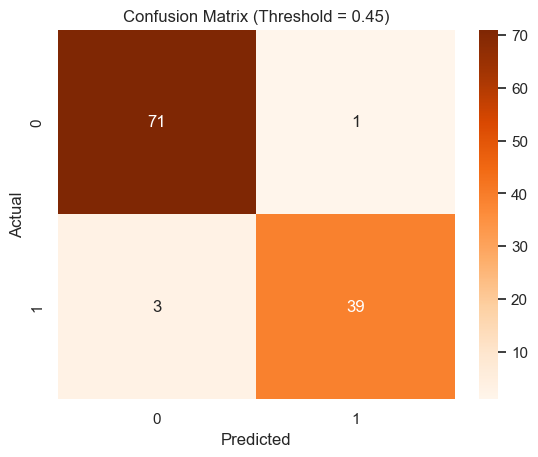

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [5]:
# Confusion matrix with adjusted threshold
cm_adj = confusion_matrix(y_test, y_pred_adj)
sns.heatmap(cm_adj, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

# Performance report with adjusted threshold
print(classification_report(y_test, y_pred_adj))


In [6]:
results_df = X_test_df.copy()
results_df["Actual"] = y_test.values
results_df["Predicted"] = y_pred
results_df["Correct"] = results_df["Actual"] == results_df["Predicted"]

In [7]:
false_positives = results_df[(results_df["Actual"] == 0) & (results_df["Predicted"] == 1)]
print(f"False Positives: {len(false_positives)}")
false_positives.head()

False Positives: 0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Actual,Predicted,Correct


In [8]:
false_negatives = results_df[(results_df["Actual"] == 1) & (results_df["Predicted"] == 0)]
# See how confident the model was about each false negative
false_negatives_indices = np.where((y_test.values == 1) & (y_pred == 0))[0]

for i in false_negatives_indices:
    print(f"Index: {i}, Prob(Malignant): {y_probs[i]:.3f}, Actual: {y_test.values[i]}, Predicted: {y_pred[i]}")
print(f"False Negatives: {len(false_negatives)}")
false_negatives.head()

Index: 16, Prob(Malignant): 0.100, Actual: 1, Predicted: 0
Index: 24, Prob(Malignant): 0.270, Actual: 1, Predicted: 0
Index: 42, Prob(Malignant): 0.190, Actual: 1, Predicted: 0
False Negatives: 3


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Actual,Predicted,Correct
16,-0.092956,-0.814392,-0.063393,-0.201331,0.308838,0.448373,-0.136966,0.045677,-0.546249,0.405774,...,-0.119860,0.382749,0.635726,0.027401,0.360776,-0.504352,1.055903,1,0,False
24,0.100174,0.505055,0.093953,-0.019024,-0.136658,-0.092312,0.396746,0.011887,0.961590,-0.912598,...,-0.126013,-0.077528,-0.360469,0.300860,0.120195,0.192911,-0.858159,1,0,False
42,0.134256,0.930909,0.082420,0.027903,-0.678938,-0.719796,-0.061511,0.097781,-0.674032,-1.224471,...,-0.215139,-0.051226,-0.611744,-0.022493,0.324232,-0.685544,-0.863701,1,0,False


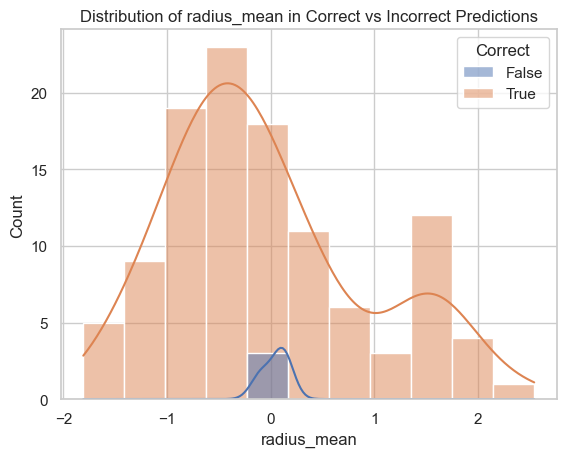

In [9]:
feature = "radius_mean"
sns.histplot(data=results_df, x=feature, hue="Correct", kde=True)
plt.title(f"Distribution of {feature} in Correct vs Incorrect Predictions")
plt.show()

## Suggestions for Improvement

- Investigate more features involved in misclassifications  
- Consider feature engineering or dimensionality reduction  
- Evaluate model calibration (e.g., prediction confidence thresholds)  
- Try ensemble or hybrid models to reduce false negatives  
- Collect more diverse training data for better generalization  
